In [129]:
import geopandas as gpd
import xarray as xr
from shapely.geometry import box
import numpy as np
from subprocess import call
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('..')
from misc.unwrap import unwrap_phase_fft
import easysnowdata as esd
import glob
from tqdm import tqdm

In [72]:
fn_1 = "/home/jehayes/sh_final/cslc/asc/OPERA_L2_CSLC-S1_T049-103322-IW2_20180103T010924Z_20240428T014600Z_S1B_VV_v1.1.h5"
fn_2 = "/home/jehayes/sh_final/cslc/asc/OPERA_L2_CSLC-S1_T049-103322-IW2_20180115T010923Z_20240428T051456Z_S1B_VV_v1.1.h5"
dsR = xr.open_dataset(fn_1,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))
tR = pd.to_datetime(xr.open_dataset(fn_1, 
                                    group='identification')['zero_doppler_start_time'].data.astype('U'))
dsS = xr.open_dataset(fn_2,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))
tS = pd.to_datetime(xr.open_dataset(fn_2, group='identification')['zero_doppler_start_time'].data.astype('U'))

In [73]:
with h5py.File(fn_1, 'r') as f:
    flat_phase1 = f['data/flattening_phase'][()]
with h5py.File(fn_2, 'r') as f:
    flat_phase2 = f['data/flattening_phase'][()]
with h5py.File(fn_1, 'r') as f:
    crs = f['/metadata/noise_information/projection'][()] 
diff_flat_phase = flat_phase2 - flat_phase1
da_wrapped_phase = xr.DataArray(
    diff_flat_phase,
    dims=['y', 'x'],
    coords={'y': dsS.y, 'x': dsS.x}
).rio.write_crs(crs)

In [75]:
np_wrapped_phase = da_wrapped_phase.values
np_unwrapped = unwrap_phase_fft(np_wrapped_phase)
da_unwrapped = xr.DataArray(np_unwrapped, 
                            dims=da_wrapped_phase.dims, 
                            coords=da_wrapped_phase.coords).rio.write_crs(crs)
da_unwrapped = da_unwrapped.where(~np.isnan(da_wrapped_phase))

In [76]:
wavelength = 0.055
da_displacement = da_unwrapped * (wavelength / (4 * np.pi))

In [77]:
gf_snotel = gpd.read_file(
    "https://github.com/egagli/snotel_ccss_stations/raw/main/all_stations.geojson"
    ).set_index("code")
gf_snotel = gf_snotel[gf_snotel.network == "SNOTEL"].reset_index()
sntl_codes = ['589_CO_SNTL', '1185_CO_SNTL', '465_CO_SNTL', 
              '586_CO_SNTL', '629_CO_SNTL', '713_CO_SNTL', '538_CO_SNTL']
gf_snotel_co_4326 = gf_snotel[gf_snotel.code.isin(sntl_codes)]
gf_snotel_co = gf_snotel_co_4326.to_crs(crs)

In [ ]:
#import xyzservices.providers as xyz
#import odc.geo.xr
#m = da_displacement.odc.explore(tiles=xyz.OpenStreetMap.Mapnik, cmap="hsv")
#gf_snotel_co[gf_snotel_co['code'] == sntl_codes[0]].explore(m=m, color='red', marker_kwds={'radius': 8})

In [119]:
results = []
for code in sntl_codes:
    # get SNOTEL data
    snotel = esd.automatic_weather_stations.StationCollection()
    snotel.get_data(code)
    df_snotel = snotel.data
    swe_reference, swe_secondary = df_snotel.loc[[tR.date(), tS.date()], "WTEQ"]
    swe_diff = swe_secondary - swe_reference
    
    # get InSAR displacement at SNOTEL location
    snotel_point = gf_snotel_co.loc[gf_snotel_co['code'] == code, 'geometry'].item()
    snotel_los_disp = da_displacement.interp(x=snotel_point.x, y=snotel_point.y, method="linear").item()
    
    # make a df for easier interpretation
    results.append({
        'sntl_code': code,
        'reference_date': tR.date(),
        'secondary_date': tS.date(),
        'snotel_los_disp': snotel_los_disp,
        'swe_diff': swe_diff
    })

df_swe = pd.DataFrame(results)

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Sta

In [ ]:
# ruh roh raggy, these results don't look promising
df_swe

,sntl_code,reference_date,secondary_date,snotel_los_disp,swe_diff
0,589_CO_SNTL,2018-01-03,2018-01-15,0.004076,0.0356
1,1185_CO_SNTL,2018-01-03,2018-01-15,-0.022206,0.0432
2,465_CO_SNTL,2018-01-03,2018-01-15,-0.020573,0.0407
3,586_CO_SNTL,2018-01-03,2018-01-15,-0.011298,0.0356
4,629_CO_SNTL,2018-01-03,2018-01-15,0.010425,0.0406
5,713_CO_SNTL,2018-01-03,2018-01-15,0.034479,0.0711
6,538_CO_SNTL,2018-01-03,2018-01-15,0.043577,0.0458


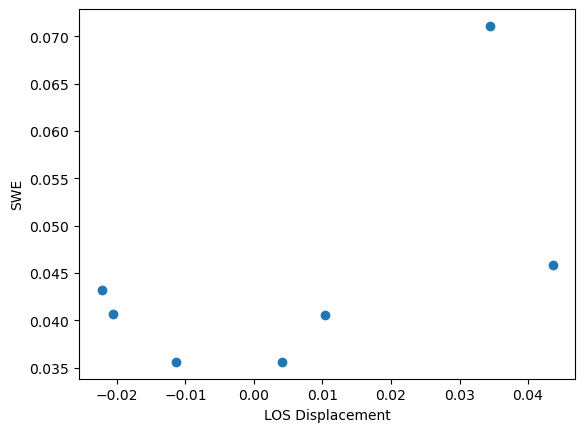

In [122]:
plt.scatter(x=df_swe.snotel_los_disp,
            y=df_swe.swe_diff)
plt.ylabel("SWE")
plt.xlabel("LOS Displacement");

In [ ]:
# oh yeah, superrrrrr obvious relationship
# let's process some more data and hopefully get some more insight on if this is actually feasible

Reference 00_SAR_intro.ipynb for how we're searching for Sentinel-1 bursts below

In [ ]:
import asf_search
bounds = gf_snotel_co_4326.total_bounds
gf_search = gpd.GeoDataFrame(
    geometry=[box(bounds[0], bounds[1], bounds[2], bounds[3])],
    crs="EPSG:4326"
)
wkt_search = gf_search.geometry.to_wkt().iloc[0]
# let's arbitrarily look for Jan-March
# stick to ascending only for now
parms = {
        'dataset':asf_search.DATASET.OPERA_S1,
        'processingLevel':asf_search.PRODUCT_TYPE.CSLC,
        'intersectsWith':wkt_search,
        'operaBurstID':['T049_103322_IW2', 'T129_275785_IW1'],
        'start':'2018-01-01T00:00:00Z',
        'end':'2018-03-31T00:00:00Z',
        'flightDirection':asf_search.FLIGHT_DIRECTION.ASCENDING,
        'maxResults':100,
}

In [ ]:
burst_hits = asf_search.search(**parms)
len(burst_hits)

In [127]:
all_urls = [url for item in burst_hits for url in [item.properties['url']]]

In [ ]:
asf_search.download_urls(urls=all_urls, path='/home/jehayes/sh_final/cslc/asc')

In [131]:
# get all our asc files we just downloaded
files = sorted(glob.glob('/home/jehayes/sh_final/cslc/asc/*.h5'))
# process each consecutive pair
# NOTE: there's more of an art to InSAR processing than just processing a pair every timestep
# but for the sake of this porject, we'll stick to this method for now
for i in tqdm(range(len(files)-1), desc="Processing pairs"):
    fn_1 = files[i]
    fn_2 = files[i+1]
    
    # reference dataset
    dsR = xr.open_dataset(fn_1, group='data', engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))
    tR = pd.to_datetime(xr.open_dataset(fn_1, group='identification')['zero_doppler_start_time'].data.astype('U'))
    # secondary dataset
    dsS = xr.open_dataset(fn_2, group='data', engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))
    tS = pd.to_datetime(xr.open_dataset(fn_2, group='identification')['zero_doppler_start_time'].data.astype('U'))   
    # topographically corrected phases
    with h5py.File(fn_1, 'r') as f:
        flat_phase1 = f['data/flattening_phase'][()]
        crs = f['/metadata/noise_information/projection'][()]
    with h5py.File(fn_2, 'r') as f:
        flat_phase2 = f['data/flattening_phase'][()]
    # phase difference
    diff_flat_phase = flat_phase2 - flat_phase1
    da_wrapped_phase = xr.DataArray(
        diff_flat_phase,
        dims=['y', 'x'],
        coords={'y': dsS.y, 'x': dsS.x}
    ).rio.write_crs(crs)
    # unwrap phase
    np_wrapped_phase = da_wrapped_phase.values
    np_unwrapped = unwrap_phase_fft(np_wrapped_phase)
    da_unwrapped = xr.DataArray(np_unwrapped,
                               dims=da_wrapped_phase.dims,
                               coords=da_wrapped_phase.coords).rio.write_crs(crs)
    da_unwrapped = da_unwrapped.where(~np.isnan(da_wrapped_phase))
    da_displacement = da_unwrapped * (wavelength / (4 * np.pi))
    
    # process SNOTEL data
    results = []
    for code in sntl_codes:
        snotel = esd.automatic_weather_stations.StationCollection()
        snotel.get_data(code)
        df_snotel = snotel.data
        
        swe_reference, swe_secondary = df_snotel.loc[[tR.date(), tS.date()], "WTEQ"]
        swe_diff = swe_secondary - swe_reference
        
        snotel_point = gf_snotel_co.loc[gf_snotel_co['code'] == code, 'geometry'].item()
        snotel_los_disp = da_displacement.interp(x=snotel_point.x, y=snotel_point.y, method="linear").item()
        
        results.append({
            'sntl_code': code,
            'reference_date': tR.date(),
            'secondary_date': tS.date(),
            'snotel_los_disp': snotel_los_disp,
            'swe_diff': swe_diff
        })
    # save DataFrame
    df_swe = pd.DataFrame(results)
    output_filename = f"../data/{tR.date()}_{tS.date()}_swe_disp.parquet"
    df_swe.to_parquet(output_filename)

Processing pairs:   0%|          | 0/5 [00:00<?, ?it/s]

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Sta

Processing pairs:  20%|██        | 1/5 [01:01<04:07, 61.87s/it]

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Sta

Processing pairs:  40%|████      | 2/5 [02:15<03:26, 68.80s/it]

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Sta

Processing pairs:  60%|██████    | 3/5 [03:28<02:21, 70.53s/it]

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Sta

Processing pairs:  80%|████████  | 4/5 [04:19<01:02, 62.80s/it]

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Sta

Processing pairs: 100%|██████████| 5/5 [06:13<00:00, 74.62s/it]


In [136]:
# now, let's inspect our five ascending pairs in Jan-March 2018 in southwestern CO
df_swe_co_jan_mar = pd.concat([pd.read_parquet(f) for f in glob.glob("../data/*.parquet")], ignore_index=True)
len(df_swe_co_jan_mar)

35

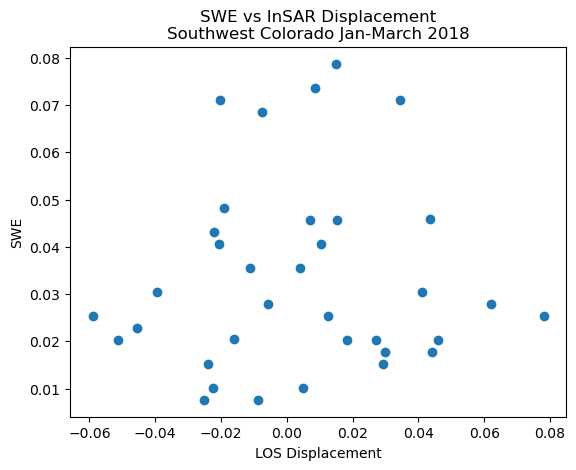

In [ ]:
# that's not great...
plt.scatter(x=df_swe_co_jan_mar.snotel_los_disp,
            y=df_swe_co_jan_mar.swe_diff)
plt.ylabel("SWE")
plt.xlabel("LOS Displacement")
plt.title("SWE vs InSAR Displacement\nSouthwest Colorado Jan-March 2018");

In [153]:
# let's try descending now because why not
parms.update({'flightDirection': asf_search.FLIGHT_DIRECTION.DESCENDING})

In [155]:
burst_hits = asf_search.search(**parms)
len(burst_hits)

8

In [156]:
all_urls = [url for item in burst_hits for url in [item.properties['url']]]
asf_search.download_urls(urls=all_urls, path='/home/jehayes/sh_final/cslc/desc')

In [157]:
# get all our desc files we just downloaded
files = sorted(glob.glob('/home/jehayes/sh_final/cslc/desc/*.h5'))
# process each consecutive pair
for i in tqdm(range(len(files)-1), desc="Processing pairs"):
    fn_1 = files[i]
    fn_2 = files[i+1]
    
    # reference dataset
    dsR = xr.open_dataset(fn_1, group='data', engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))
    tR = pd.to_datetime(xr.open_dataset(fn_1, group='identification')['zero_doppler_start_time'].data.astype('U'))
    # secondary dataset
    dsS = xr.open_dataset(fn_2, group='data', engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))
    tS = pd.to_datetime(xr.open_dataset(fn_2, group='identification')['zero_doppler_start_time'].data.astype('U'))   
    # topographically corrected phases
    with h5py.File(fn_1, 'r') as f:
        flat_phase1 = f['data/flattening_phase'][()]
        crs = f['/metadata/noise_information/projection'][()]
    with h5py.File(fn_2, 'r') as f:
        flat_phase2 = f['data/flattening_phase'][()]
    # phase difference
    diff_flat_phase = flat_phase2 - flat_phase1
    da_wrapped_phase = xr.DataArray(
        diff_flat_phase,
        dims=['y', 'x'],
        coords={'y': dsS.y, 'x': dsS.x}
    ).rio.write_crs(crs)
    # unwrap phase
    np_wrapped_phase = da_wrapped_phase.values
    np_unwrapped = unwrap_phase_fft(np_wrapped_phase)
    da_unwrapped = xr.DataArray(np_unwrapped,
                               dims=da_wrapped_phase.dims,
                               coords=da_wrapped_phase.coords).rio.write_crs(crs)
    da_unwrapped = da_unwrapped.where(~np.isnan(da_wrapped_phase))
    da_displacement = da_unwrapped * (wavelength / (4 * np.pi))
    
    # process SNOTEL data
    results = []
    for code in sntl_codes:
        snotel = esd.automatic_weather_stations.StationCollection()
        snotel.get_data(code)
        df_snotel = snotel.data
        
        swe_reference, swe_secondary = df_snotel.loc[[tR.date(), tS.date()], "WTEQ"]
        swe_diff = swe_secondary - swe_reference
        
        snotel_point = gf_snotel_co.loc[gf_snotel_co['code'] == code, 'geometry'].item()
        snotel_los_disp = da_displacement.interp(x=snotel_point.x, y=snotel_point.y, method="linear").item()
        
        results.append({
            'sntl_code': code,
            'reference_date': tR.date(),
            'secondary_date': tS.date(),
            'snotel_los_disp': snotel_los_disp,
            'swe_diff': swe_diff
        })
    # save DataFrame
    df_swe = pd.DataFrame(results)
    output_filename = f"../data/{tR.date()}_{tS.date()}_desc_swe_disp.parquet"
    df_swe.to_parquet(output_filename)

Processing pairs:   0%|          | 0/7 [00:00<?, ?it/s]

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Sta

Processing pairs:  14%|█▍        | 1/7 [00:42<04:17, 42.94s/it]

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Sta

Processing pairs:  29%|██▊       | 2/7 [01:21<03:21, 40.23s/it]

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Sta

Processing pairs:  43%|████▎     | 3/7 [01:55<02:30, 37.51s/it]

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Sta

Processing pairs:  57%|█████▋    | 4/7 [02:29<01:48, 36.28s/it]

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Sta

Processing pairs:  71%|███████▏  | 5/7 [03:07<01:13, 36.74s/it]

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Sta

Processing pairs:  86%|████████▌ | 6/7 [03:44<00:36, 36.84s/it]

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data attribute to access.
Geodataframe with all stations has been added to the Sta

Processing pairs: 100%|██████████| 7/7 [04:20<00:00, 37.15s/it]


In [158]:
df_swe_co_desc = pd.concat([pd.read_parquet(f) for f in glob.glob("../data/*desc*.parquet")], ignore_index=True)
len(df_swe_co_desc)

49

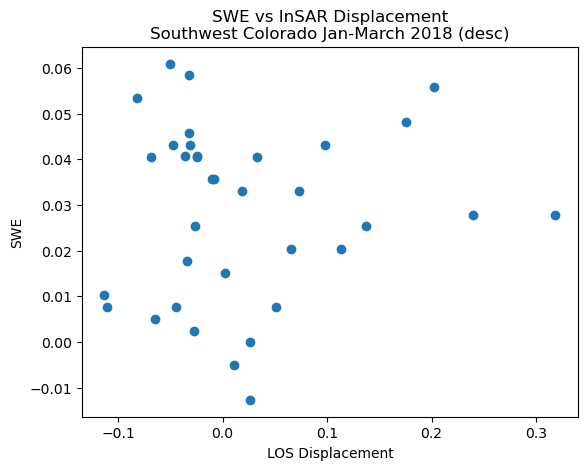

In [160]:
# that's also not great
plt.scatter(x=df_swe_co_desc.snotel_los_disp,
            y=df_swe_co_desc.swe_diff)
plt.ylabel("SWE")
plt.xlabel("LOS Displacement")
plt.title("SWE vs InSAR Displacement\nSouthwest Colorado Jan-March 2018 (desc)");

In [161]:
df_swe_co_jan_mar['track'] = 'asc'
df_swe_co_desc['track'] = 'desc'

In [162]:
df_co_swe_disp = pd.concat([df_swe_co_jan_mar, df_swe_co_desc], ignore_index=True)

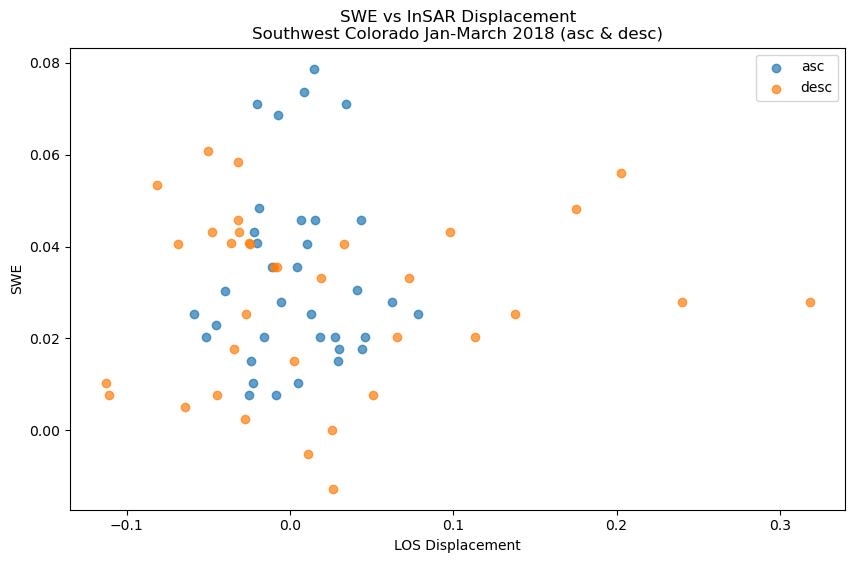

In [ ]:
# welp
plt.figure(figsize=(10, 6))
for track_type in df_co_swe_disp["track"].unique():
    mask = df_co_swe_disp["track"] == track_type
    plt.scatter(x=df_co_swe_disp.loc[mask, "snotel_los_disp"],
                y=df_co_swe_disp.loc[mask, "swe_diff"],
                label=track_type, alpha=0.7)

plt.ylabel("SWE")
plt.xlabel("LOS Displacement")
plt.title("SWE vs InSAR Displacement\nSouthwest Colorado Jan-March 2018 (asc & desc)")
plt.legend();

In [ ]:
# TODO: spend the rest of the project diving into why this doesn't work
# we sort of know the answer, but let's try and relate it to the snowpack characteristics
# and dielectric properties